In [1]:

import os
directory_changed = False
try:
    from simulations.drosselschwab import simulate_drosselschwab
except:
    print("Adjusting path for imports...")
    os.chdir("..")
    directory_changed = True
    from simulations.drosselschwab import simulate_drosselschwab

print(os.getcwd())

import results
import data
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
import csv
import os
from pathlib import Path
from datetime import datetime
from scripts.parallel_sims import worker
import numpy as np

Adjusting path for imports...
/home/ijsbrand/CMS/CS/Project/CSS_project-19


In [2]:
# Create experiments root under data/f_over_p and pick the next available experiment index
if directory_changed:
    base_dir = Path("data/f_param").resolve()
else:
    base_dir = Path("../data/f_param").resolve()

base_dir.mkdir(parents=True, exist_ok=True)
idx = 1
while (base_dir / f"experiment_{idx}").exists():
    idx += 1
outdir = base_dir / f"experiment_{idx}"
outdir.mkdir(parents=True, exist_ok=False)
print(f"Saving notebook run results to experiment directory: {outdir}")

Saving notebook run results to experiment directory: /home/ijsbrand/CMS/CS/Project/CSS_project-19/data/f_param/experiment_5


In [3]:
# Example parameter sweep: small demo grid. Replace with your actual sweep.
param_list = []
param_idx = 1
L = 256
steps = 5000
p = 0.1
runs_per_param = 5

f_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1]

for f in f_values:
    for run_idx in range(runs_per_param):
        param_list.append({'L': L, 'p': p, 'f': f, 'steps': steps, 'param_id': param_idx, 'run_id': run_idx})
    param_idx += 1

param_list

[{'L': 256, 'p': 0.1, 'f': 1e-05, 'steps': 5000, 'param_id': 1, 'run_id': 0},
 {'L': 256, 'p': 0.1, 'f': 1e-05, 'steps': 5000, 'param_id': 1, 'run_id': 1},
 {'L': 256, 'p': 0.1, 'f': 1e-05, 'steps': 5000, 'param_id': 1, 'run_id': 2},
 {'L': 256, 'p': 0.1, 'f': 1e-05, 'steps': 5000, 'param_id': 1, 'run_id': 3},
 {'L': 256, 'p': 0.1, 'f': 1e-05, 'steps': 5000, 'param_id': 1, 'run_id': 4},
 {'L': 256, 'p': 0.1, 'f': 0.0001, 'steps': 5000, 'param_id': 2, 'run_id': 0},
 {'L': 256, 'p': 0.1, 'f': 0.0001, 'steps': 5000, 'param_id': 2, 'run_id': 1},
 {'L': 256, 'p': 0.1, 'f': 0.0001, 'steps': 5000, 'param_id': 2, 'run_id': 2},
 {'L': 256, 'p': 0.1, 'f': 0.0001, 'steps': 5000, 'param_id': 2, 'run_id': 3},
 {'L': 256, 'p': 0.1, 'f': 0.0001, 'steps': 5000, 'param_id': 2, 'run_id': 4},
 {'L': 256, 'p': 0.1, 'f': 0.001, 'steps': 5000, 'param_id': 3, 'run_id': 0},
 {'L': 256, 'p': 0.1, 'f': 0.001, 'steps': 5000, 'param_id': 3, 'run_id': 1},
 {'L': 256, 'p': 0.1, 'f': 0.001, 'steps': 5000, 'param_id'

In [25]:
max_workers = int(os.environ.get('MAX_WORKERS', multiprocessing.cpu_count()))
print(f"Running {len(param_list)} simulations with up to {max_workers} workers...")

results = []
with ProcessPoolExecutor(max_workers=max_workers) as exe:
    # pass outdir as first argument to worker
    futures = {exe.submit(worker, outdir, params): params for params in param_list}
    for fut in as_completed(futures):
        params = futures[fut]
        try:
            res = fut.result()
            print(f"Done: p={res['p']}, f={res['f']}, fires={res['num_fires']}, mean={res['mean_size']:.2f}, max={res['max_size']}")
            results.append(res)
        except Exception as e:
            print(f"Error for params {params}: {e}")

# Write a summary CSV
summary_file = outdir / f"summary_{datetime.now().strftime('%Y%m%dT%H%M%SZ')}.csv"
keys = ['L', 'p', 'f', 'steps', 'param_id', 'run_id', 'num_fires', 'mean_size', 'max_size', 'remaining_trees', 'raw_file']
with open(summary_file, 'w', newline='') as fh:
    writer = csv.DictWriter(fh, keys)
    writer.writeheader()
    for r in results:
        writer.writerow({k: r.get(k, '') for k in keys})

print(f"Summary written to {summary_file}")


Running 35 simulations with up to 8 workers...
Done: p=0.1, f=0.0001, fires=13170, mean=1552.94, max=37508
Done: p=0.1, f=0.0001, fires=13234, mean=1544.07, max=37037
Done: p=0.1, f=0.0001, fires=13093, mean=1561.69, max=35827
Done: p=0.1, f=1e-05, fires=1446, mean=13472.19, max=58327
Done: p=0.1, f=1e-05, fires=1445, mean=13442.19, max=58800
Done: p=0.1, f=1e-05, fires=1409, mean=13872.03, max=58494
Done: p=0.1, f=1e-05, fires=1420, mean=13694.00, max=56932
Done: p=0.1, f=1e-05, fires=1441, mean=13361.98, max=60095
Done: p=0.1, f=0.01, fires=1061094, mean=21.88, max=568
Done: p=0.1, f=0.001, fires=124199, mean=171.48, max=6401
Done: p=0.1, f=0.0001, fires=13120, mean=1556.74, max=34977
Done: p=0.1, f=0.0001, fires=13341, mean=1530.94, max=34252
Done: p=0.1, f=0.001, fires=123929, mean=171.79, max=6692
Done: p=0.1, f=0.001, fires=124284, mean=171.33, max=7551
Done: p=0.1, f=0.001, fires=124211, mean=171.48, max=7142
Done: p=0.1, f=0.001, fires=123644, mean=172.28, max=5561
Done: p=0.1,

In [ ]:
# --- New analysis cells: load per-step CSVs from the latest experiment and compute statistics ---
import json
import csv
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# auto-detect latest experiment directory under data/f_over_p
if not base_dir.exists():
    raise FileNotFoundError(f"Base data directory not found: {base_dir}")
exp_dirs = [d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith('experiment_')]
if not exp_dirs:
    raise FileNotFoundError(f"No experiment directories found under {base_dir}")
def _exp_index(d):
    try:
        return int(d.name.split('_')[-1])
    except Exception:
        return -1
exp_dirs_sorted = sorted(exp_dirs, key=_exp_index)
EXP_DIR = exp_dirs_sorted[-1].resolve()
print('Experiment dir:', EXP_DIR)

# find perstep files created by the worker
perstep_files = sorted(EXP_DIR.glob('perstep_param*_*.csv'))
print(f'Found {len(perstep_files)} per-step files')

# filename pattern to extract param_id and run_id
pattern = re.compile(r'perstep_param(?P<param>\d+)_.*_id(?P<run>\d+)_')


def load_perstep_file(fp):
    records = []
    with open(fp, newline='') as fh:
        reader = csv.reader(fh)
        try:
            header = next(reader)
        except StopIteration:
            return records
        for row in reader:
            if not row:
                continue
            # expected columns: step, fire_size (JSON), cluster distr (JSON), mean tree density
            step = int(row[0])
            fires = json.loads(row[1]) if row[1] else []
            clusters = json.loads(row[2]) if row[2] else []
            density = float(row[3]) if row[3] != '' else None
            records.append({'step': step, 'fires': fires, 'clusters': clusters, 'density': density})
    return records

# organize runs by param_id
runs_by_param = {}  # param_id -> list of runs
for fp in perstep_files:
    m = pattern.search(fp.name)
    if not m:
        print('Skipping unknown file pattern:', fp.name)
        continue
    pid = int(m.group('param'))
    rid = int(m.group('run'))
    recs = load_perstep_file(fp)
    # aggregate series for convenience
    fires_all = []
    clusters_all = []
    density_series = []
    for r in recs:
        fires_all.extend(r['fires'])
        clusters_all.extend(r['clusters'])
        density_series.append(r['density'])
    runs_by_param.setdefault(pid, []).append({'run_id': rid, 'file': fp, 'records': recs, 'fires_all': fires_all, 'clusters_all': clusters_all, 'density_series': density_series})

print('Loaded runs for param_ids:', sorted(runs_by_param.keys()))

Experiment dir: /home/ijsbrand/CMS/CS/Project/CSS_project-19/data/f_param/experiment_4
Found 35 per-step files


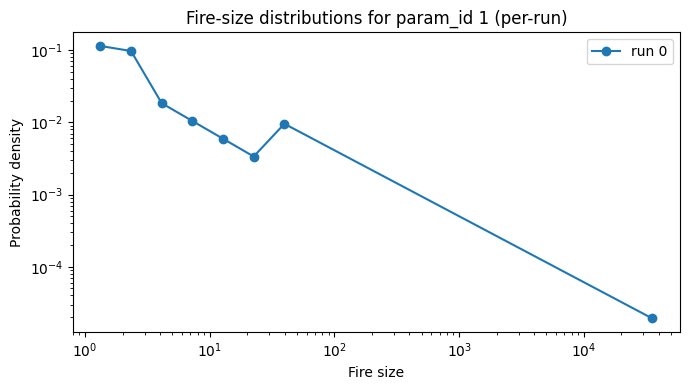

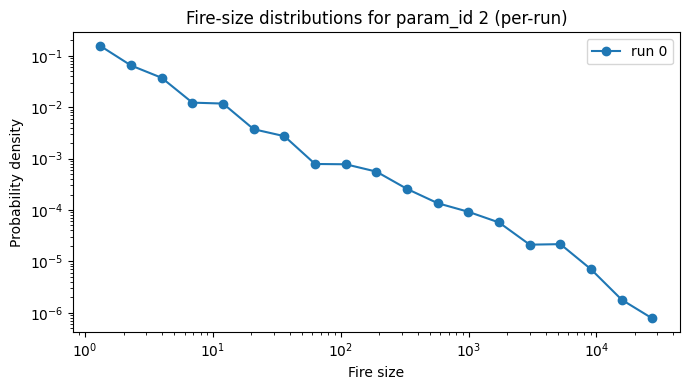

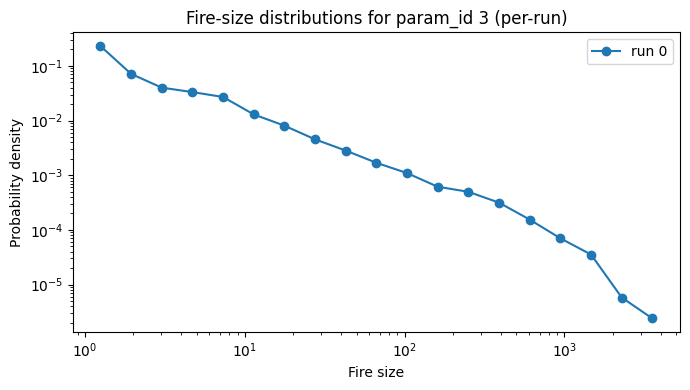

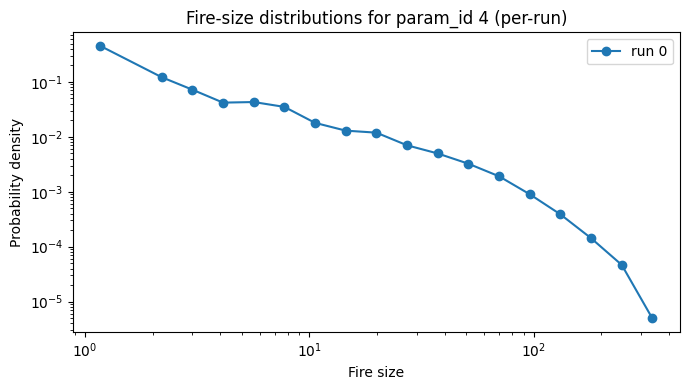

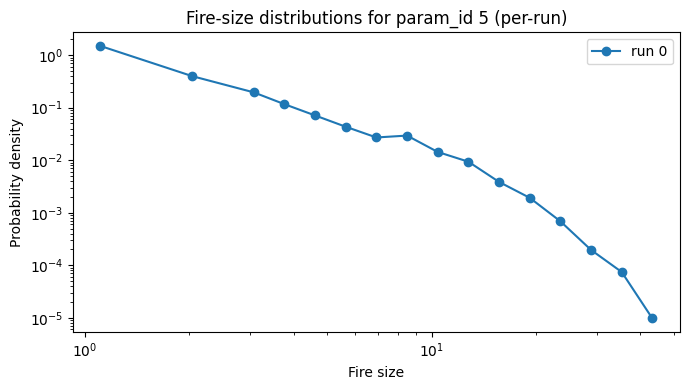

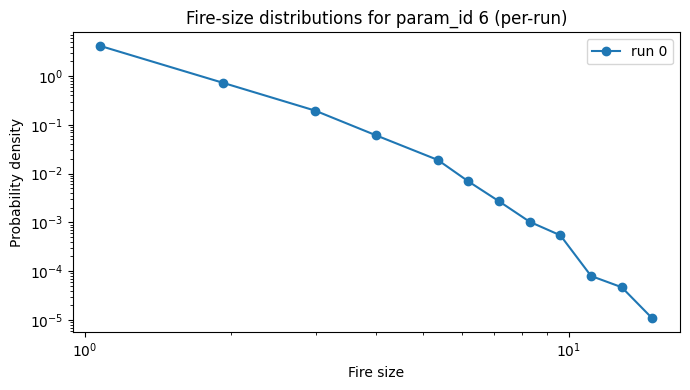

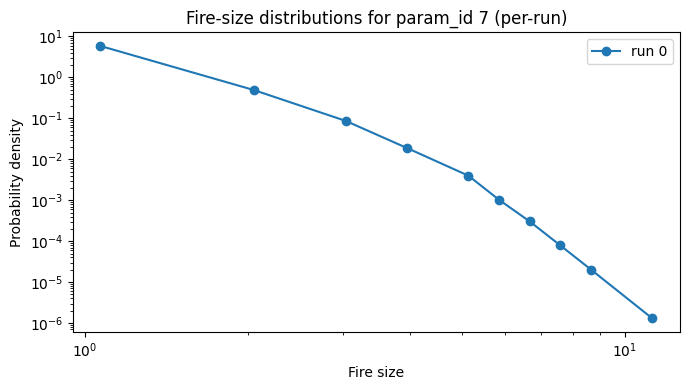

In [19]:
# Plot: Fire-size distributions for individual runs with the same param_id
# Choose a param_id to inspect (if multiple present, this will loop over all)
for pid in sorted(runs_by_param.keys()):
    runs = runs_by_param[pid]
    if not runs:
        continue
    plt.figure(figsize=(7, 4))
    # compute global min/max across runs for consistent bins
    all_fs = np.concatenate([np.array(r['fires_all']) for r in runs if len(r['fires_all']) > 0]) if any(len(r['fires_all'])>0 for r in runs) else np.array([])
    if all_fs.size == 0:
        print(f'param_id {pid}: no fires recorded in any run')
        continue
    min_s = max(1, int(all_fs.min()))
    max_s = int(all_fs.max())
    bins = np.logspace(np.log10(min_s), np.log10(max_s), num=20)

    for r in runs:
        fs = np.array(r['fires_all'])
        if fs.size == 0:
            continue
        hist, edges = np.histogram(fs, bins=bins, density=True)
        centers = np.sqrt(edges[:-1] * edges[1:])
        mask = hist > 0
        plt.loglog(centers[mask], hist[mask], marker='o', linestyle='-', label=f"run {r['run_id']}")

    plt.title(f'Fire-size distributions for param_id {pid} (per-run)')
    plt.xlabel('Fire size')
    plt.ylabel('Probability density')
    plt.legend()
    plt.tight_layout()
    plt.show()


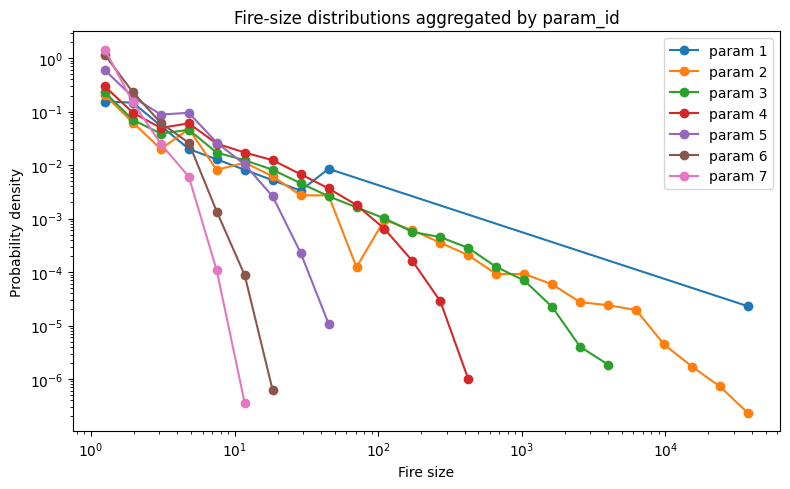

In [20]:
# Plot: Fire-size distributions aggregated across runs for different param_ids
# compute global bins across all param_ids
all_fires_global = np.concatenate([np.concatenate([np.array(r['fires_all']) for r in runs_by_param[pid] if len(r['fires_all'])>0]) for pid in runs_by_param.keys() if any(len(r['fires_all'])>0 for r in runs_by_param[pid])]) if any(any(len(r['fires_all'])>0 for r in runs_by_param[pid]) for pid in runs_by_param.keys()) else np.array([])
if all_fires_global.size > 0:
    min_s = max(1, int(all_fires_global.min()))
    max_s = int(all_fires_global.max())
    bins = np.logspace(np.log10(min_s), np.log10(max_s), num=25)

    plt.figure(figsize=(8, 5))
    for pid in sorted(runs_by_param.keys()):
        runs = runs_by_param[pid]
        # aggregate fires across runs for this param_id
        agg = np.concatenate([np.array(r['fires_all']) for r in runs if len(r['fires_all']) > 0]) if any(len(r['fires_all'])>0 for r in runs) else np.array([])
        if agg.size == 0:
            continue
        hist, edges = np.histogram(agg, bins=bins, density=True)
        centers = np.sqrt(edges[:-1] * edges[1:])
        mask = hist > 0
        plt.loglog(centers[mask], hist[mask], marker='o', linestyle='-', label=f'param {pid}')

    plt.title('Fire-size distributions aggregated by param_id')
    plt.xlabel('Fire size')
    plt.ylabel('Probability density')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No fires in any run to plot aggregated distributions')


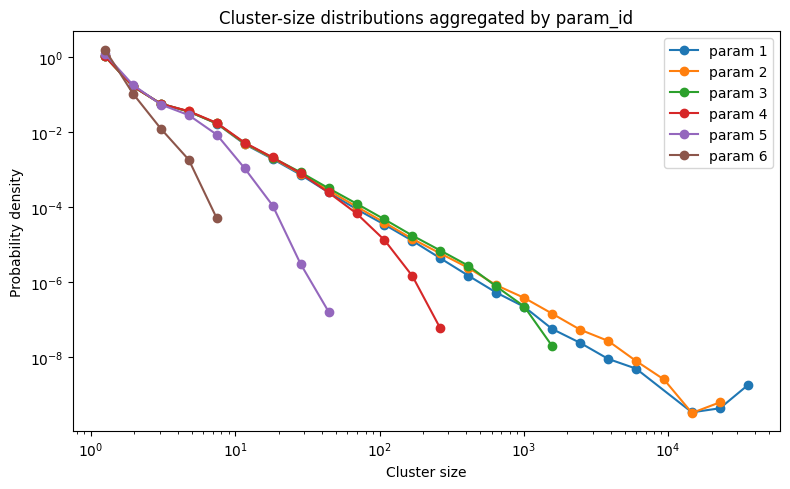

In [21]:
# Plot: Cluster-size distributions (aggregated across runs and steps) per param_id
all_clusters_global = np.concatenate([np.concatenate([np.array(r['clusters_all']) for r in runs_by_param[pid] if len(r['clusters_all'])>0]) for pid in runs_by_param.keys() if any(len(r['clusters_all'])>0 for r in runs_by_param[pid])]) if any(any(len(r['clusters_all'])>0 for r in runs_by_param[pid]) for pid in runs_by_param.keys()) else np.array([])
if all_clusters_global.size > 0:
    min_c = max(1, int(all_clusters_global.min()))
    max_c = int(all_clusters_global.max())
    bins = np.logspace(np.log10(min_c), np.log10(max_c), num=25)

    plt.figure(figsize=(8, 5))
    for pid in sorted(runs_by_param.keys()):
        runs = runs_by_param[pid]
        agg = np.concatenate([np.array(r['clusters_all']) for r in runs if len(r['clusters_all']) > 0]) if any(len(r['clusters_all'])>0 for r in runs) else np.array([])
        if agg.size == 0:
            continue
        hist, edges = np.histogram(agg, bins=bins, density=True)
        centers = np.sqrt(edges[:-1] * edges[1:])
        mask = hist > 0
        plt.loglog(centers[mask], hist[mask], marker='o', linestyle='-', label=f'param {pid}')

    plt.title('Cluster-size distributions aggregated by param_id')
    plt.xlabel('Cluster size')
    plt.ylabel('Probability density')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No clusters recorded in any run')


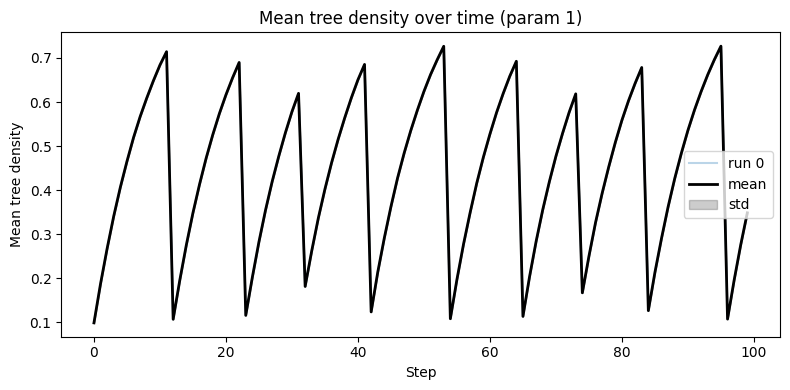

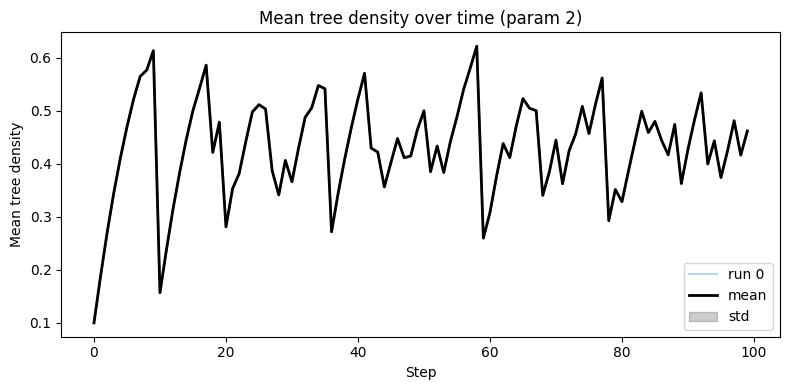

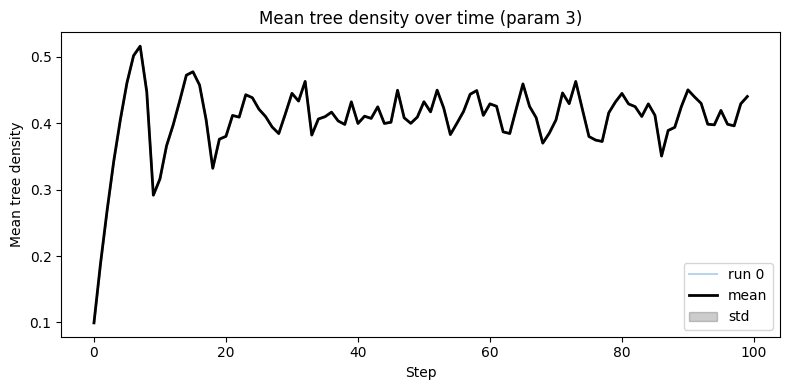

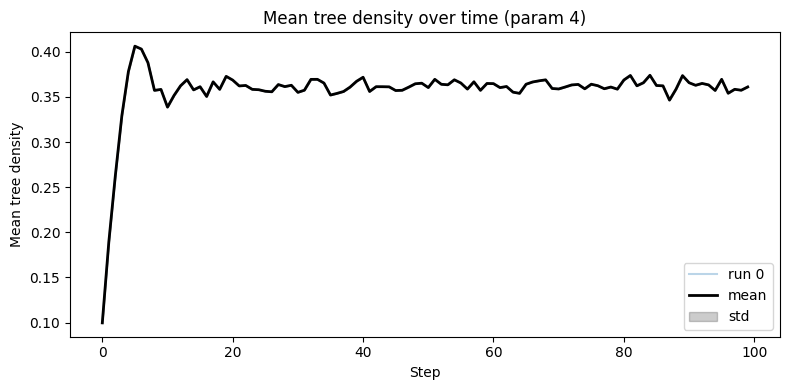

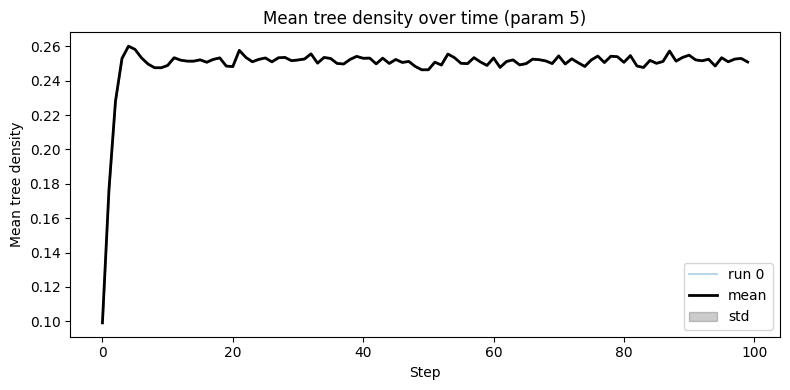

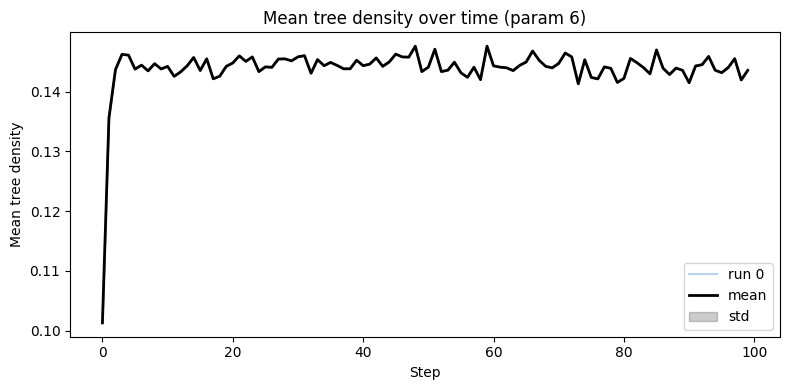

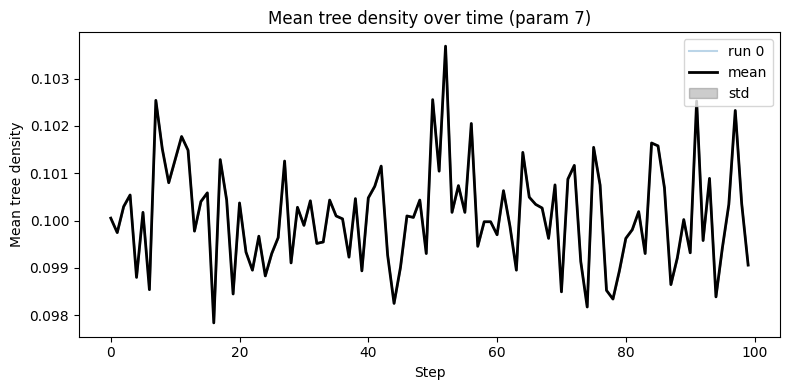

In [22]:
# Plot: Mean tree density time series per run and averaged per param_id
for pid in sorted(runs_by_param.keys()):
    runs = runs_by_param[pid]
    if not runs:
        continue
    plt.figure(figsize=(8, 4))
    # collect arrays of densities; pad shorter runs if needed
    densities = [np.array(r['density_series'], dtype=float) for r in runs if len(r['density_series'])>0]
    if not densities:
        print(f'param {pid}: no density series available')
        continue
    maxlen = max(arr.size for arr in densities)
    stacked = np.vstack([np.pad(arr, (0, maxlen - arr.size), constant_values=np.nan) for arr in densities])
    # plot individual runs
    for i, arr in enumerate(stacked):
        plt.plot(np.arange(arr.size), arr, alpha=0.3, label=f'run {runs[i]["run_id"]}')
    # mean and std across runs (ignore nan)
    mean_series = np.nanmean(stacked, axis=0)
    std_series = np.nanstd(stacked, axis=0)
    x = np.arange(mean_series.size)
    plt.plot(x, mean_series, color='k', linewidth=2, label='mean')
    plt.fill_between(x, mean_series - std_series, mean_series + std_series, color='k', alpha=0.2, label='std')
    plt.title(f'Mean tree density over time (param {pid})')
    plt.xlabel('Step')
    plt.ylabel('Mean tree density')
    plt.legend()
    plt.tight_layout()
    plt.show()
